In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install '/content/drive/MyDrive/Colab Notebooks/cw_daicon/eTaPR-21.8.2-py3-none-any.whl'

Processing ./drive/MyDrive/Colab Notebooks/cw_daicon/eTaPR-21.8.2-py3-none-any.whl


In [3]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/cw_daicon"

In [5]:
TRAIN_DATASET = sorted([x for x in Path(path+"/train/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/train/train1.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/train/train2.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/train/train3.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/train/train4.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/train/train5.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/train/train6.csv')]

In [6]:
TEST_DATASET = sorted([x for x in Path(path+"/test/").glob("*.csv")])
TEST_DATASET

[PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/test/test1.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/test/test2.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/test/test3.csv')]

In [7]:
VALIDATION_DATASET = sorted([x for x in Path(path+"/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('/content/drive/MyDrive/Colab Notebooks/cw_daicon/validation/validation.csv')]

In [8]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [9]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)

In [10]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])

In [11]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [12]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [13]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()   #alpha=0.9 : 10일간의 가중 평균값 적용. 값 커질수록 과거 데이터 영향↑ (https://m.blog.naver.com/nilsine11202/221903150950)

In [14]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [15]:
boundary_check(TRAIN_DF)

(False, False, False)

In [16]:
TRAIN_DF.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
count,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1004402.0,1004402.0,1.004402e+06,...,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06
mean,4.689247e-01,0.0,5.278706e-02,5.117928e-01,6.441084e-01,4.895708e-01,7.260389e-01,4.480288e-01,0.0,0.0,5.568204e-01,4.420350e-01,4.805930e-01,5.094487e-01,4.616315e-01,3.201560e-01,8.009442e-02,0.0,0.0,4.422457e-01,5.104590e-01,0.0,3.756326e-01,4.686994e-01,1.314718e-01,0.0,3.740849e-01,3.900405e-01,0.0,8.126308e-01,5.160247e-01,2.878237e-01,4.624067e-01,8.009542e-02,4.503195e-01,0.0,5.920433e-01,0.0,0.0,6.434621e-01,...,2.383182e-01,9.199046e-01,0.0,3.489676e-01,2.812433e-01,0.0,3.724140e-01,1.060923e-01,0.0,3.773795e-01,5.332380e-01,2.861885e-01,3.027391e-01,5.603719e-01,9.199056e-01,7.445102e-01,0.0,8.009442e-02,3.926838e-01,4.720739e-01,6.914062e-01,3.465613e-01,0.0,3.527244e-01,9.178944e-01,6.496661e-01,4.563804e-01,6.892669e-01,3.144097e-01,2.985862e-01,3.597938e-01,5.770209e-01,4.192900e-01,6.892614e-01,5.033529e-01,0.0,5.173684e-01,1.871145e-05,0.0,9.448133e-02
std,1.816325e-01,0.0,2.711736e-02,1.849803e-02,4.099142e-01,1.789313e-01,2.993505e-01,4.972917e-01,0.0,0.0,2.363175e-01,7.590298e-02,1.126587e-01,1.560596e-01,1.591929e-01,6.814898e-02,2.714361e-01,0.0,0.0,2.581816e-01,1.571319e-01,0.0,1.254172e-01,1.902598e-01,2.105272e-01,0.0,1.269231e-01,1.220844e-01,0.0,2.075257e-01,1.412957e-01,3.610861e-02,1.917853e-01,2.714377e-01,2.816137e-01,0.0,3.479060e-01,0.0,0.0,4.459473e-01,...,3.908300e-01,2.714377e-01,0.0,3.631968e-01,2.322583e-01,0.0,3.323141e-01,1.858230e-01,0.0,1.361663e-01,2.868380e-01,2.639609e-01,1.314794e-01,7.246362e-02,2.714361e-01,1.864767e-01,0.0,2.714361e-01,3.462591e-01,2.995527e-01,4.188168e-01,5.978501e-02,0.0,4.397380e-02,2.304715e-01,4.091513e-01,1.461112e-01,4.183055e-01,6.853947e-02,1.299605e-01,5.788084e-02,2.927475e-01,3.445783e-01,4.183084e-01,2.254592e-01,0.0,1.717591e-01,3.333650e-03,0.0,1.291178e-01
min,7.951789e-03,0.0,1.565067e-04,5.181067e-02,1.516766e-05,8.401645e-04,0.000000e+00,0.000000e+00,0.0,0.0,2.247562e-04,4.411495e-05,4.643382e-02,2.277656e-04,1.442858e-301,5.558370e-04,0.000000e+00,0.0,0.0,0.000000e+00,2.008994e-04,0.0,3.195172e-04,9.495737e-05,1.547908e-03,0.0,8.620651e-04,5.113238e-04,0.0,0.000000e+00,6.886625e-05,2.658585e-04,1.386976e-02,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,9.220850e-05,...,1.962637e-05,0.000000e+00,0.0,5.728324e-06,9.777582e-05,0.0,5.753460e-07,5.377667e-04,0.0,7.638681e-04,0.000000e+00,0.000000e+00,4.365269e-05,5.438629e-03,0.000000e+00,4.854168e-03,0.0,0.000000e+00,8.136689e-05,0.000000e+00,0.000000e+00,1.676462e-03,0.0,3.258180e-04,0.000000e+00,0.000000e+00,5.849880e-05,3.828065e-04,5.898816e-05,3.536042e-04,3.931927e-04,6.443158e-05,0.000000e+00,3.828065e-04,4.992635e-04,0.0,0.000000e+00,0.000000e+00,0.0,9.004197e-04
25%,3.573124e-01,0.

In [17]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW.head()

#valid : 86,400 row * 88 col

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,50,10289,11.68213,28.03510,27181,27.84305,29.50472,0,1,50,27.796206,31.04248,1,334.58112,437.98016,3,50,18131,1.04366,1,54830,1032.43347,57.25861,4.9870,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,71.77734,0.44952,0,292.86029,431.328095,20.989594,51.26343,720.02826,1,927,0,0,15184,0.059445,14.91310,10000,1,300.11276,35.0,15.09755,264.01520,438.15259,30.90057,50.63332,1.22543,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,50,10266,11.68213,28.03419,27174,27.84305,29.41619,0,1,50,27.796206,31.04248,1,332.97162,437.62238,2,50,18111,1.04217,1,54829,1032.43347,57.06784,5.3008,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,74.29114,0.44723,0,295.82605,431.328095,20.989594,51.26343,719.85382,1,926,0,0,14224,0.059445,14.95540,9999,1,298.12650,35.0,14.71477,264.01520,465.95908,30.88531,50.64244,1.22543,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,50,10238,11.68213,28.03429,27172,27.84305,29.31749,0,1,50,27.796206,31.04248,1,332.15784,437.11121,2,50,18100,1.03920,1,54828,1031.79565,56.68636,4.5175,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,70.54761,0.43884,0,300.02173,431.328095,20.989594,51.26343,719.92407,1,927,0,0,12368,0.059445,14.99200,9999,1,297.13321,35.0,14.30731,263.63373,452.05582,30.58014,50.65156,1.21475,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,50,10215,11.68213,28.03686,27168,27.84305,29.26632,0,1,50,27.796206,31.04248,1,330.96429,437.16232,2,50,18000,1.03222,1,54829,1033.07117,56.68636,5.4640,0,129.60573,2880,27.736847,0,0,...,1,0,8,45.33997,1,59.44373,0.42435,0,302.10144,431.328095,20.989594,51.26343,720.02954,1,924,0,0,11888,0.059445,15.01359,9999,1,295.14697,35.0,14.54943,264.39661,434.18011,30.06897,50.68747,1.20255,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,50,10085,11.68213,28.02990,27172,27.84305,29.20597,0,1,50,27.796206,31.04248,1,329.02917,437.11121,2,50,17852,1.02947,1,54830,1031.47668,55.73270,4.5850,0,129.60573,2880,27.736847,0,0,...,1,0,688,45.33997,1,57.27356,0.40451,0,305.03113,431.328095,20.989594,51.14899,720.02905,1,927,0,0,10688,0.059445,15.04767,9999,1,295.14697,35.0,15.24461,263.44296,411.33905,30.05371,50.64556,1.20483,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0


In [18]:
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,50,10289,11.68213,28.03510,27181,27.84305,29.50472,0,1,50,27.796206,31.04248,1,334.58112,437.98016,3,50,18131,1.04366,1,54830,1032.43347,57.25861,4.9870,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,71.77734,0.44952,0,292.86029,431.328095,20.989594,51.26343,720.02826,1,927,0,0,15184,0.059445,14.91310,10000,1,300.11276,35.00000,15.09755,264.01520,438.15259,30.90057,50.63332,1.22543,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,50,10266,11.68213,28.03419,27174,27.84305,29.41619,0,1,50,27.796206,31.04248,1,332.97162,437.62238,2,50,18111,1.04217,1,54829,1032.43347,57.06784,5.3008,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,74.29114,0.44723,0,295.82605,431.328095,20.989594,51.26343,719.85382,1,926,0,0,14224,0.059445,14.95540,9999,1,298.12650,35.00000,14.71477,264.01520,465.95908,30.88531,50.64244,1.22543,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,50,10238,11.68213,28.03429,27172,27.84305,29.31749,0,1,50,27.796206,31.04248,1,332.15784,437.11121,2,50,18100,1.03920,1,54828,1031.79565,56.68636,4.5175,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,70.54761,0.43884,0,300.02173,431.328095,20.989594,51.26343,719.92407,1,927,0,0,12368,0.059445,14.99200,9999,1,297.13321,35.00000,14.30731,263.63373,452.05582,30.58014,50.65156,1.21475,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,50,10215,11.68213,28.03686,27168,27.84305,29.26632,0,1,50,27.796206,31.04248,1,330.96429,437.16232,2,50,18000,1.03222,1,54829,1033.07117,56.68636,5.4640,0,129.60573,2880,27.736847,0,0,...,1,0,8,45.33997,1,59.44373,0.42435,0,302.10144,431.328095,20.989594,51.26343,720.02954,1,924,0,0,11888,0.059445,15.01359,9999,1,295.14697,35.00000,14.54943,264.39661,434.18011,30.06897,50.68747,1.20255,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,50,10085,11.68213,28.02990,27172,27.84305,29.20597,0,1,50,27.796206,31.04248,1,329.02917,437.11121,2,50,17852,1.02947,1,54830,1031.47668,55.73270,4.5850,0,129.60573,2880,27.736847,0,0,...,1,0,688,45.33997,1,57.27356,0.40451,0,305.03113,431.328095,20.989594,51.14899,720.02905,1,927,0,0,10688,0.059445,15.04767,9999,1,295.14697,35.00000,15.24461,263.44296,411.33905,30.05371,50.64556,1.20483,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,50,6494,14.42108,28.02736,27265,27.86172,37.79226,0,1,50,27.796206,31.98853,1,354.96240,455.76889,3,50,19244,1.24152,1,54727,1021.90936,70.03782,5.2654,0,109.91794,2880,27.804180,0,0,...,1,0,8,39.84681,1,0.56064,1.38260,0,347.45734,451.941960,20.989594,50.21057,720.00098,1,905,0,0,16,0.193330,35.65305,10022,1,360.69107,25.53188,15.29280,257.72092,1179.76929,38.01117,49.54745,1.25824,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,50,6496,14.41345,28.03598,27262,27.86

In [19]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
boundary_check(VALIDATION_DF)   #최소.최대값 넘어가는 값 존재(공격 존재)

(True, True, False)

## EDA


*   몇초씩 공격이 진행되는지 
*   5가지의 공격 패턴 어떻게 다른가



In [20]:
valid_eda = pd.concat([VALIDATION_DF_RAW.loc[:,['timestamp','attack']],VALIDATION_DF],axis=1)
valid_eda.head()

,timestamp,attack,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-10 00:00:01,0,0.474293,0.0,-0.040688,0.519147,0.159551,0.481116,1.11916,0.0,0.0,0.0,0.311277,0.330391,0.476523,0.465288,0.391755,0.252807,0.0,0.0,0.0,0.843921,0.454746,0.0,0.388589,0.397988,0.00658,0.0,0.377818,0.317642,0.0,0.997037,0.595393,0.255575,0.273939,0.0,0.990896,0.0,0.307856,0.0,...,0.415335,1.0,0.0,0.000578,0.697652,0.0,0.760553,0.115451,0.0,0.234528,0.369551,0.419792,0.328804,0.529181,1.0,0.937500,0.0,0.0,0.778682,0.030846,0.149131,0.410377,0.0,0.315322,1.0,0.150976,0.531332,0.134334,0.259555,0.323196,0.437871,0.339753,0.071604,0.118089,0.467573,0.0,0.624077,0.0,0.0,0.020832
1,2021-07-10 00:00:02,0,0.449457,0.0,-0.040688,0.478203,0.155911,0.484458,1.11916,0.0,0.0,0.0,0.309995,0.330391,0.453796,0.454948,0.391755,0.251523,0.0,0.0,0.0,0.843921,0.454746,0.0,0.382426,0.395788,0.00642,0.0,0.376386,0.315900,0.0,0.995556,0.595393,0.254717,0.328891,0.0,0.990896,0.0,0.307856,0.0,...,0.412390,1.0,0.0,0.000578,0.697652,0.0,0.787223,0.113588,0.0,0.245657,0.369551,0.419792,0.328804,0.350979,1.0,0.930556,0.0,0.0,0.729862,0.030846,0.149554,0.408019,0.0,0.313220,1.0,0.147148,0.531332,0.143081,0.259336,0.323598,0.437871,0.339406,0.071604,0.125899,0.450619,0.0,0.624077,0.0,0.0,0.020374
2,2021-07-10 00:00:03,0,0.374232,0.0,-0.042253,0.464234,0.144385,0.418439,1.11916,0.0,0.0,0.0,0.308434,0.330391,0.456294,0.451994,0.391755,0.250091,0.0,0.0,0.0,0.843921,0.454746,0.0,0.379310,0.392644,0.00642,0.0,0.375599,0.312428,0.0,0.994074,0.593139,0.253001,0.191720,0.0,0.990896,0.0,0.307856,0.0,...,0.427207,1.0,0.0,0.000578,0.697652,0.0,0.747506,0.106762,0.0,0.261401,0.369551,0.419792,0.328804,0.422744,1.0,0.937500,0.0,0.0,0.635476,0.030846,0.149920,0.408019,0.0,0.312169,1.0,0.143073,0.528721,0.138707,0.254956,0.324000,0.430914,0.337903,0.071604,0.134334,0.434069,0.0,0.624077,0.0,0.0,0.019916
3,2021-07-10 00:00:04,0,0.394981,0.0,-0.040688,0.493858,0.143702,0.467821,1.11916,0.0,0.0,0.0,0.307152,0.330391,0.520480,0.446086,0.391755,0.249349,0.0,0.0,0.0,0.843921,0.454746,0.0,0.374740,0.392958,0.00642,0.0,0.368444,0.304269,0.0,0.995556,0.597646,0.253001,0.357471,0.0,0.990896,0.0,0.307856,0.0,...,0.449165,1.0,0.0,0.001156,0.697652,0.0,0.629701,0.094973,0.0,0.269205,0.369551,0.419792,0.328804,0.530489,1.0,0.916667,0.0,0.0,0.611066,0.030846,0.150136,0.408019,0.0,0.310066,1.0,0.145494,0.533942,0.133084,0.247618,0.325584,0.422966,0.335552,0.071604,0.143081,0.406889,0.0,0.624077,0.0,0.0,0.019840
4,2021-07-10 00:00:05,0,0.439027,0.0,-0.042253,0.520833,0.144309,0.445991,1.11916,0.0,0.0,0.0,0.299905,0.330391,0.346653,0.451994,0.391755,0.248473,0.0,0.0,0.0,0.843921,0.454746,0.0,0.367331,0.392644,0.00642,0.0,0.357853,0.301054,0.0,0.997037,0.592011,0.248713,0.203541,0.0,0.990896,0.0,0.307856,0.0,...,0.471659,1.0,0.0,0.050289,0.697652,0.0,0.606677,0.078831,0.0,0.280198,0.369551,0.419792,0.323832,0.529988,1.0,0.937500,0.0,0.0,0.550041,0.030846,0.150477,0.408019,0.0,0.310066,1.0,0.152446,0.527415,0.125899,0.247399,0.323736,0.424451,0.335552,0.071604,0.138707,0.387715,0.0,0.624077,0.0,0.0,0.019840


In [21]:
val_attack = valid_eda[valid_eda['attack']==1]
val_attack

,timestamp,attack,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
20481,2021-07-10 05:41:22,1,0.315908,0.0,-0.040688,0.530467,0.142792,0.413453,1.119160,0.0,0.0,0.0,0.767936,0.512249,0.455544,0.465288,0.455236,0.265293,0.0,0.0,0.0,0.843921,0.472406,0.0,0.521396,0.348318,0.006580,0.0,0.527084,0.553983,0.0,0.888889,0.324280,0.306175,0.313428,0.0,0.529215,0.0,0.307856,0.0,...,0.387575,1.0,0.0,0.056069,0.389432,0.0,0.728895,0.172559,0.0,0.557071,0.388430,0.419792,0.206165,0.525749,1.0,0.826389,0.0,0.0,0.777055,0.674174,0.228604,0.283019,0.0,0.375233,1.000000,0.185277,0.275457,0.164637,0.242252,0.232266,0.306161,0.376141,0.071604,0.175258,0.828579,0.0,0.279507,0.0,0.0,0.009081
20482,2021-07-10 05:41:23,1,0.400535,0.0,-0.040688,0.502529,0.163343,0.453167,1.119160,0.0,0.0,0.0,0.766765,0.512249,0.497752,0.477105,0.455236,0.266916,0.0,0.0,0.0,0.843921,0.474614,0.0,0.528112,0.349261,0.006580,0.0,0.536744,0.554111,0.0,0.888889,0.328891,0.311321,0.325897,0.0,0.529215,0.0,0.307856,0.0,...,0.371775,1.0,0.0,0.053179,0.390412,0.0,0.735035,0.189319,0.0,0.570100,0.388430,0.419792,0.205833,0.490464,1.0,0.826389,0.0,0.0,0.782750,0.674174,0.229469,0.283019,0.0,0.381539,1.000000,0.183702,0.279373,0.182444,0.242909,0.231382,0.303679,0.376179,0.071604,0.159326,0.842640,0.0,0.279507,0.0,0.0,0.009081
20483,2021-07-10 05:41:24,1,0.460619,0.0,-0.042253,0.514812,0.171533,0.455830,1.119160,0.0,0.0,0.0,0.766598,0.512249,0.389610,0.469719,0.455236,0.269267,0.0,0.0,0.0,0.843921,0.470198,0.0,0.528112,0.351776,0.006580,0.0,0.535957,0.560938,0.0,0.888889,0.325817,0.319039,0.254483,0.0,0.529215,0.0,0.307856,0.0,...,0.349014,1.0,0.0,0.050289,0.389432,0.0,0.741942,0.225948,0.0,0.564061,0.388430,0.419792,0.206165,0.490893,1.0,0.833333,0.0,0.0,0.787632,0.674174,0.230230,0.283019,0.0,0.390999,1.000000,0.175736,0.276762,0.212747,0.258898,0.228810,0.323562,0.378146,0.071604,0.164637,0.832683,0.0,0.279507,0.0,0.0,0.009081
20484,2021-07-10 05:41:25,1,0.406877,0.0,-0.040688,0.514812,0.172215,0.455830,1.119160,0.0,0.0,0.0,0.766598,0.512249,0.389610,0.469719,0.455236,0.259939,0.0,0.0,0.0,0.843921,0.472406,0.0,0.528112,0.354920,0.006580,0.0,0.536315,0.563872,0.0,0.888889,0.330427,0.319039,0.254483,0.0,0.529215,0.0,0.307856,0.0,...,0.326698,1.0,0.0,0.047977,0.388454,0.0,0.746355,0.268158,0.0,0.570372,0.388430,0.419792,0.206165,0.490893,1.0,0.833333,0.0,0.0,0.794142,0.674174,0.231360,0.308962,0.0,0.390999,1.000000,0.161495,0.280679,0.242290,0.260650,0.230036,0.327535,0.378993,0.071604,0.182444,0.844187,0.0,0.279507,0.0,0.0,0.009081
20485,2021-07-10 05:41:26,1,0.306725,0.0,-0.042253,0.501686,0.172291,0.378121,1.119160,0.0,0.0,0.0,0.766263,0.512249,0.435315,0.469719,0.455236,0.260850,0.0,0.0,0.0,0.843921,0.470198,0.0,0.531921,0.355863,0.006580,0.0,0.536315,0.562539,0.0,0.888889,0.328891,0.320755,0.189409,0.0,0.529215,0.0,0.307856,0.0,...,0.304293,1.0,0.0,0.047977,0.387475,0.0,0.746355,0.310368,0.0,0.570372,0.388430,0.419792,0.206165,0.598208,1.0,0.833333,0.0,0.0,0.794142,0.674174,0.231920,0.308962,0.0,0.393101,1.000000,0.147057,0.279373,0.256244,0.260870,0.227387,0.328031,0.378608,0.071604,0.212747,0.844187,0.0,0.279507,0.0,0.0,0.009081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81382,2021-07-10 22:36:23,1,0.314130,0.0,0.056338,0.508671,0.100099,0.384182,0.816071,0.0,0.0,0.0,0.191872,0.470978,0.324675,0.552437,0.377581,0.291903,0.0,0.0,0.0,0.843921,0.549668,0.0,0.498546,0.463376,0.044616,0.0,0.500394,0.583850,0.0,0.842963,0.555946,0.3061

In [22]:
attack_time = []
start_time = []
index = []
time = 0
for i in range(1,86400):
    if valid_eda.loc[i]['attack']==1 :
        if valid_eda.loc[i]['attack'] == valid_eda.loc[i-1]['attack'] :
            time += 1
        else : 
            time = 0
            time += 1
            start_time.append(valid_eda.loc[i]['timestamp'])
    elif valid_eda.loc[i]['attack']==0 and valid_eda.loc[i-1]['attack'] == 1:
        attack_time.append(time)
        time = 0
attack_time

[191, 55, 127, 55, 297, 92, 68]

In [23]:
start_time

['2021-07-10 05:41:22',
 '2021-07-10 07:19:12',
 '2021-07-10 11:25:13',
 '2021-07-10 15:39:12',
 '2021-07-10 16:42:17',
 '2021-07-10 19:21:16',
 '2021-07-10 22:35:20']

In [24]:
# VALIDATION_DF

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f166e333510>,
                 k=None, metric=None, model=None, timings=True)

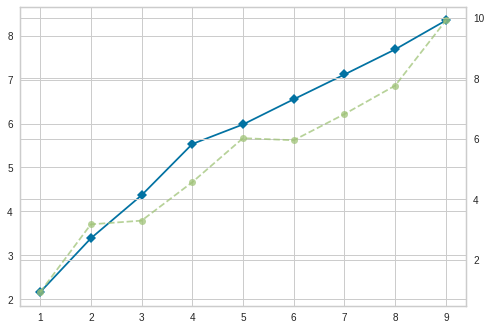

In [25]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
 
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(VALIDATION_DF)
 

In [26]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=6) # 주성분을 몇개로 할지 결정
# printcipalComponents = pca.fit_transform(VALIDATION_DF)
# principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# # 주성분으로 이루어진 데이터 프레임 구성

In [27]:
# K-means clustering
from sklearn.cluster import KMeans

all_points = VALIDATION_DF.values
kmeans = KMeans(n_clusters=6).fit(all_points)
# kmeans.labels_  #각 데이터에 대한 클러스터 결과물

VALIDATION_DF['cluster_id'] = kmeans.labels_
VALIDATION_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,cluster_id
0,0.474293,0.0,-0.040688,0.519147,0.159551,0.481116,1.119160,0.0,0.0,0.0,0.311277,0.330391,0.476523,0.465288,0.391755,0.252807,0.0,0.0,0.0,0.843921,0.454746,0.0,0.388589,0.397988,0.00658,0.0,0.377818,0.317642,0.0,0.997037,0.595393,0.255575,0.273939,0.0,0.990896,0.0,0.307856,0.0,0.0,0.032358,...,1.0,0.0,0.000578,0.697652,0.0,0.760553,0.115451,0.0,0.234528,0.369551,0.419792,0.328804,0.529181,1.0,0.937500,0.0,0.0,0.778682,0.030846,0.149131,0.410377,0.0,0.315322,1.000000,0.150976,0.531332,0.134334,0.259555,0.323196,0.437871,0.339753,0.071604,0.118089,0.467573,0.0,0.624077,0.0,0.0,0.020832,1
1,0.449457,0.0,-0.040688,0.478203,0.155911,0.484458,1.119160,0.0,0.0,0.0,0.309995,0.330391,0.453796,0.454948,0.391755,0.251523,0.0,0.0,0.0,0.843921,0.454746,0.0,0.382426,0.395788,0.00642,0.0,0.376386,0.315900,0.0,0.995556,0.595393,0.254717,0.328891,0.0,0.990896,0.0,0.307856,0.0,0.0,0.034465,...,1.0,0.0,0.000578,0.697652,0.0,0.787223,0.113588,0.0,0.245657,0.369551,0.419792,0.328804,0.350979,1.0,0.930556,0.0,0.0,0.729862,0.030846,0.149554,0.408019,0.0,0.313220,1.000000,0.147148,0.531332,0.143081,0.259336,0.323598,0.437871,0.339406,0.071604,0.125899,0.450619,0.0,0.624077,0.0,0.0,0.020374,1
2,0.374232,0.0,-0.042253,0.464234,0.144385,0.418439,1.119160,0.0,0.0,0.0,0.308434,0.330391,0.456294,0.451994,0.391755,0.250091,0.0,0.0,0.0,0.843921,0.454746,0.0,0.379310,0.392644,0.00642,0.0,0.375599,0.312428,0.0,0.994074,0.593139,0.253001,0.191720,0.0,0.990896,0.0,0.307856,0.0,0.0,0.033411,...,1.0,0.0,0.000578,0.697652,0.0,0.747506,0.106762,0.0,0.261401,0.369551,0.419792,0.328804,0.422744,1.0,0.937500,0.0,0.0,0.635476,0.030846,0.149920,0.408019,0.0,0.312169,1.000000,0.143073,0.528721,0.138707,0.254956,0.324000,0.430914,0.337903,0.071604,0.134334,0.434069,0.0,0.624077,0.0,0.0,0.019916,1
3,0.394981,0.0,-0.040688,0.493858,0.143702,0.467821,1.119160,0.0,0.0,0.0,0.307152,0.330391,0.520480,0.446086,0.391755,0.249349,0.0,0.0,0.0,0.843921,0.454746,0.0,0.374740,0.392958,0.00642,0.0,0.368444,0.304269,0.0,0.995556,0.597646,0.253001,0.357471,0.0,0.990896,0.0,0.307856,0.0,0.0,0.032057,...,1.0,0.0,0.001156,0.697652,0.0,0.629701,0.094973,0.0,0.269205,0.369551,0.419792,0.328804,0.530489,1.0,0.916667,0.0,0.0,0.611066,0.030846,0.150136,0.408019,0.0,0.310066,1.000000,0.145494,0.533942,0.133084,0.247618,0.325584,0.422966,0.335552,0.071604,0.143081,0.406889,0.0,0.624077,0.0,0.0,0.019840,1
4,0.439027,0.0,-0.042253,0.520833,0.144309,0.445991,1.119160,0.0,0.0,0.0,0.299905,0.330391,0.346653,0.451994,0.391755,0.248473,0.0,0.0,0.0,0.843921,0.454746,0.0,0.367331,0.392644,0.00642,0.0,0.357853,0.301054,0.0,0.997037,0.592011,0.248713,0.203541,0.0,0.990896,0.0,0.307856,0.0,0.0,0.030326,...,1.0,0.0,0.050289,0.697652,0.0,0.606677,0.078831,0.0,0.280198,0.369551,0.419792,0.323832,0.529988,1.0,0.937500,0.0,0.0,0.550041,0.030846,0.150477,0.408019,0.0,0.310066,1.000000,0.152446,0.527415,0.125899,0.247399,0.323736,0.424451,0.335552,0.071604,0.138707,0.387715,0.0,0.624077,0.0,0.0,0.019840,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.332148,0.0,0.056338,0.527818,0.151740,0.395815,0.816071,0.0,0.0,0.0,0.099727,0.409622,0.283217,0.589365,0.396085,0.373033,0.0,0.0,0.0,0.843921,0.591612,0.0,0.466625,0.507388,0.00658,0.0,0.457460,0.548933,0.0,0.844444,0.558200,0.313036,0.322692,0.0,0.329096,0.0,0.315971,0.0,0.0,0.131688,...,1.0,0.0,0.001156,0.345402,0.0,0.004989,0.874615,0.0,0.439400,0.564127,0

In [28]:
VALIDATION_DF_time = VALIDATION_DF.copy()
VALIDATION_DF_time['timestamp'] = valid_eda['timestamp']
VALIDATION_DF_time

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,cluster_id,timestamp
0,0.474293,0.0,-0.040688,0.519147,0.159551,0.481116,1.119160,0.0,0.0,0.0,0.311277,0.330391,0.476523,0.465288,0.391755,0.252807,0.0,0.0,0.0,0.843921,0.454746,0.0,0.388589,0.397988,0.00658,0.0,0.377818,0.317642,0.0,0.997037,0.595393,0.255575,0.273939,0.0,0.990896,0.0,0.307856,0.0,0.0,0.032358,...,0.0,0.000578,0.697652,0.0,0.760553,0.115451,0.0,0.234528,0.369551,0.419792,0.328804,0.529181,1.0,0.937500,0.0,0.0,0.778682,0.030846,0.149131,0.410377,0.0,0.315322,1.000000,0.150976,0.531332,0.134334,0.259555,0.323196,0.437871,0.339753,0.071604,0.118089,0.467573,0.0,0.624077,0.0,0.0,0.020832,1,2021-07-10 00:00:01
1,0.449457,0.0,-0.040688,0.478203,0.155911,0.484458,1.119160,0.0,0.0,0.0,0.309995,0.330391,0.453796,0.454948,0.391755,0.251523,0.0,0.0,0.0,0.843921,0.454746,0.0,0.382426,0.395788,0.00642,0.0,0.376386,0.315900,0.0,0.995556,0.595393,0.254717,0.328891,0.0,0.990896,0.0,0.307856,0.0,0.0,0.034465,...,0.0,0.000578,0.697652,0.0,0.787223,0.113588,0.0,0.245657,0.369551,0.419792,0.328804,0.350979,1.0,0.930556,0.0,0.0,0.729862,0.030846,0.149554,0.408019,0.0,0.313220,1.000000,0.147148,0.531332,0.143081,0.259336,0.323598,0.437871,0.339406,0.071604,0.125899,0.450619,0.0,0.624077,0.0,0.0,0.020374,1,2021-07-10 00:00:02
2,0.374232,0.0,-0.042253,0.464234,0.144385,0.418439,1.119160,0.0,0.0,0.0,0.308434,0.330391,0.456294,0.451994,0.391755,0.250091,0.0,0.0,0.0,0.843921,0.454746,0.0,0.379310,0.392644,0.00642,0.0,0.375599,0.312428,0.0,0.994074,0.593139,0.253001,0.191720,0.0,0.990896,0.0,0.307856,0.0,0.0,0.033411,...,0.0,0.000578,0.697652,0.0,0.747506,0.106762,0.0,0.261401,0.369551,0.419792,0.328804,0.422744,1.0,0.937500,0.0,0.0,0.635476,0.030846,0.149920,0.408019,0.0,0.312169,1.000000,0.143073,0.528721,0.138707,0.254956,0.324000,0.430914,0.337903,0.071604,0.134334,0.434069,0.0,0.624077,0.0,0.0,0.019916,1,2021-07-10 00:00:03
3,0.394981,0.0,-0.040688,0.493858,0.143702,0.467821,1.119160,0.0,0.0,0.0,0.307152,0.330391,0.520480,0.446086,0.391755,0.249349,0.0,0.0,0.0,0.843921,0.454746,0.0,0.374740,0.392958,0.00642,0.0,0.368444,0.304269,0.0,0.995556,0.597646,0.253001,0.357471,0.0,0.990896,0.0,0.307856,0.0,0.0,0.032057,...,0.0,0.001156,0.697652,0.0,0.629701,0.094973,0.0,0.269205,0.369551,0.419792,0.328804,0.530489,1.0,0.916667,0.0,0.0,0.611066,0.030846,0.150136,0.408019,0.0,0.310066,1.000000,0.145494,0.533942,0.133084,0.247618,0.325584,0.422966,0.335552,0.071604,0.143081,0.406889,0.0,0.624077,0.0,0.0,0.019840,1,2021-07-10 00:00:04
4,0.439027,0.0,-0.042253,0.520833,0.144309,0.445991,1.119160,0.0,0.0,0.0,0.299905,0.330391,0.346653,0.451994,0.391755,0.248473,0.0,0.0,0.0,0.843921,0.454746,0.0,0.367331,0.392644,0.00642,0.0,0.357853,0.301054,0.0,0.997037,0.592011,0.248713,0.203541,0.0,0.990896,0.0,0.307856,0.0,0.0,0.030326,...,0.0,0.050289,0.697652,0.0,0.606677,0.078831,0.0,0.280198,0.369551,0.419792,0.323832,0.529988,1.0,0.937500,0.0,0.0,0.550041,0.030846,0.150477,0.408019,0.0,0.310066,1.000000,0.152446,0.527415,0.125899,0.247399,0.323736,0.424451,0.335552,0.071604,0.138707,0.387715,0.0,0.624077,0.0,0.0,0.019840,1,2021-07-10 00:00:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.332148,0.0,0.056338,0.527818,0.151740,0.395815,0.816071,0.0,0.0,0.0,0.099727,0.409622,0.283217,0.589365,0.396085,0.373033,0.0,0.0,0.0,0.843921,0.591612,0.0,0.466625,0.507388,0.00658,0.0,0.457460,0.548933,0.0,0.844444,0.558200,0.313036,0.322692,0.0,0.329096,0.0,0.315971,0.0,0.

In [29]:
attack_cluster = []
for stime in start_time :
    id = VALIDATION_DF_time[VALIDATION_DF_time['timestamp'] == stime]['cluster_id']
    attack_cluster.append(id)
attack_cluster

[20481    5
 Name: cluster_id, dtype: int32, 26351    2
 Name: cluster_id, dtype: int32, 41112    5
 Name: cluster_id, dtype: int32, 56351    1
 Name: cluster_id, dtype: int32, 60136    0
 Name: cluster_id, dtype: int32, 69675    5
 Name: cluster_id, dtype: int32, 81319    2
 Name: cluster_id, dtype: int32]

In [30]:
attack_time

[191, 55, 127, 55, 297, 92, 68]

In [31]:
start_time

['2021-07-10 05:41:22',
 '2021-07-10 07:19:12',
 '2021-07-10 11:25:13',
 '2021-07-10 15:39:12',
 '2021-07-10 16:42:17',
 '2021-07-10 19:21:16',
 '2021-07-10 22:35:20']

In [32]:
for i in range(6) : 
    print(i ,' : ' ,len(VALIDATION_DF_time[VALIDATION_DF_time['cluster_id'] == i]))

0  :  4509
1  :  23695
2  :  21341
3  :  7009
4  :  12996
5  :  16850


In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)    # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(VALIDATION_DF.drop(['cluster_id'],axis=1))
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['P_component1', 'P_component2'])
principalDf

,P_component1,P_component2
0,-0.395110,-0.627640
1,-0.453350,-0.603522
2,-0.462114,-0.529950
3,-0.474024,-0.453045
4,-0.495261,-0.379424
...,...,...
86395,0.402379,-0.008919
86396,0.518141,-0.030363
86397,0.498636,-0.029885
86398,0.496269,-0.026636


In [34]:
pca_result = pd.concat([principalDf,VALIDATION_DF_time.loc[:,['cluster_id']]],axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


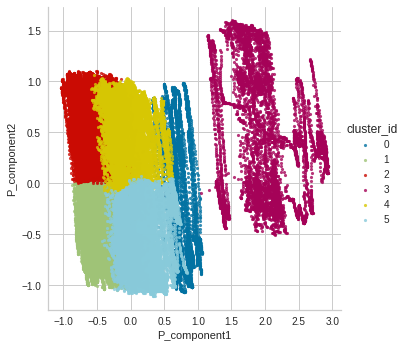

In [35]:
sns.lmplot('P_component1','P_component2', data=pca_result, fit_reg=False, scatter_kws={'s':10}, hue='cluster_id')
plt.show()

In [36]:
principalDf_1 = pca_result[pca_result['cluster_id']==1]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


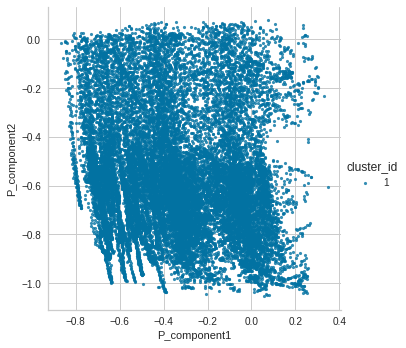

In [37]:
# cluster별 분포 확인
sns.lmplot('P_component1','P_component2', data=principalDf_1, fit_reg=False, scatter_kws={'s':10}, hue='cluster_id')

In [38]:
#최소 최대 넘어가는 값중에 공격이 아닌 경우

In [41]:
val_no_normal = valid_eda.copy()

In [45]:
valid_eda

,timestamp,attack,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-10 00:00:01,0,0.474293,0.0,-0.040688,0.519147,0.159551,0.481116,1.119160,0.0,0.0,0.0,0.311277,0.330391,0.476523,0.465288,0.391755,0.252807,0.0,0.0,0.0,0.843921,0.454746,0.0,0.388589,0.397988,0.00658,0.0,0.377818,0.317642,0.0,0.997037,0.595393,0.255575,0.273939,0.0,0.990896,0.0,0.307856,0.0,...,0.415335,1.0,0.0,0.000578,0.697652,0.0,0.760553,0.115451,0.0,0.234528,0.369551,0.419792,0.328804,0.529181,1.0,0.937500,0.0,0.0,0.778682,0.030846,0.149131,0.410377,0.0,0.315322,1.000000,0.150976,0.531332,0.134334,0.259555,0.323196,0.437871,0.339753,0.071604,0.118089,0.467573,0.0,0.624077,0.0,0.0,0.020832
1,2021-07-10 00:00:02,0,0.449457,0.0,-0.040688,0.478203,0.155911,0.484458,1.119160,0.0,0.0,0.0,0.309995,0.330391,0.453796,0.454948,0.391755,0.251523,0.0,0.0,0.0,0.843921,0.454746,0.0,0.382426,0.395788,0.00642,0.0,0.376386,0.315900,0.0,0.995556,0.595393,0.254717,0.328891,0.0,0.990896,0.0,0.307856,0.0,...,0.412390,1.0,0.0,0.000578,0.697652,0.0,0.787223,0.113588,0.0,0.245657,0.369551,0.419792,0.328804,0.350979,1.0,0.930556,0.0,0.0,0.729862,0.030846,0.149554,0.408019,0.0,0.313220,1.000000,0.147148,0.531332,0.143081,0.259336,0.323598,0.437871,0.339406,0.071604,0.125899,0.450619,0.0,0.624077,0.0,0.0,0.020374
2,2021-07-10 00:00:03,0,0.374232,0.0,-0.042253,0.464234,0.144385,0.418439,1.119160,0.0,0.0,0.0,0.308434,0.330391,0.456294,0.451994,0.391755,0.250091,0.0,0.0,0.0,0.843921,0.454746,0.0,0.379310,0.392644,0.00642,0.0,0.375599,0.312428,0.0,0.994074,0.593139,0.253001,0.191720,0.0,0.990896,0.0,0.307856,0.0,...,0.427207,1.0,0.0,0.000578,0.697652,0.0,0.747506,0.106762,0.0,0.261401,0.369551,0.419792,0.328804,0.422744,1.0,0.937500,0.0,0.0,0.635476,0.030846,0.149920,0.408019,0.0,0.312169,1.000000,0.143073,0.528721,0.138707,0.254956,0.324000,0.430914,0.337903,0.071604,0.134334,0.434069,0.0,0.624077,0.0,0.0,0.019916
3,2021-07-10 00:00:04,0,0.394981,0.0,-0.040688,0.493858,0.143702,0.467821,1.119160,0.0,0.0,0.0,0.307152,0.330391,0.520480,0.446086,0.391755,0.249349,0.0,0.0,0.0,0.843921,0.454746,0.0,0.374740,0.392958,0.00642,0.0,0.368444,0.304269,0.0,0.995556,0.597646,0.253001,0.357471,0.0,0.990896,0.0,0.307856,0.0,...,0.449165,1.0,0.0,0.001156,0.697652,0.0,0.629701,0.094973,0.0,0.269205,0.369551,0.419792,0.328804,0.530489,1.0,0.916667,0.0,0.0,0.611066,0.030846,0.150136,0.408019,0.0,0.310066,1.000000,0.145494,0.533942,0.133084,0.247618,0.325584,0.422966,0.335552,0.071604,0.143081,0.406889,0.0,0.624077,0.0,0.0,0.019840
4,2021-07-10 00:00:05,0,0.439027,0.0,-0.042253,0.520833,0.144309,0.445991,1.119160,0.0,0.0,0.0,0.299905,0.330391,0.346653,0.451994,0.391755,0.248473,0.0,0.0,0.0,0.843921,0.454746,0.0,0.367331,0.392644,0.00642,0.0,0.357853,0.301054,0.0,0.997037,0.592011,0.248713,0.203541,0.0,0.990896,0.0,0.307856,0.0,...,0.471659,1.0,0.0,0.050289,0.697652,0.0,0.606677,0.078831,0.0,0.280198,0.369551,0.419792,0.323832,0.529988,1.0,0.937500,0.0,0.0,0.550041,0.030846,0.150477,0.408019,0.0,0.310066,1.000000,0.152446,0.527415,0.125899,0.247399,0.323736,0.424451,0.335552,0.071604,0.138707,0.387715,0.0,0.624077,0.0,0.0,0.019840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,0,0.332148,0.0,0.056338,0.527818,0.151740,0.395815,0.816071,0.0,0.0,0.0,0.099727,0.409622,0.283217,0.589365,0.396085,0.373033,0.0,0.0,0.0,0.843921,0.591612,0.0,0.466625,0.507388,0.00658,0.0,0.457460,0.548933,0.0,0.844444,0.558200,0.313036,0.322692,0.0,0.329096,0

In [44]:
def not_normal(x):
    y = np.array(x, dtype=np.float32)
    if np.any(y > 1.0) or np.any(y < 0) :
        if x['attack'] == 1:
            return TP
        else :
            return FN
    else :
        if x['attack'] == 1:
            return FP  # 0인데 1로
        else :
            return TN

val_no_normal['TF'] = valid_eda.drop(['timestamp'],axis=1).apply(not_normal)
val_no_normal

KeyError: ignored